In [1]:
!pip install -q ipython-autotime
%load_ext autotime


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
time: 267 µs (started: 2024-02-07 05:56:44 +00:00)


In [2]:
!python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"

time: 2.42 s (started: 2024-02-07 05:56:47 +00:00)


In [3]:
!pip install -qqq git+https://github.com/huggingface/transformers --progress-bar off
!pip install -qqq git+https://github.com/huggingface/datasets --progress-bar off
!pip install -qqq git+https://github.com/huggingface/peft --progress-bar off
!pip install -qqq git+https://github.com/huggingface/accelerate --progress-bar off
!pip install -qqq --upgrade bitsandbytes --progress-bar off
!pip install -qqq git+https://github.com/huggingface/trl --progress-bar off
!pip install -qqq --upgrade safetensors --progress-bar off
!pip install -qqq -U flash-attn --progress-bar off
!pip install -qqq evaluate --progress-bar off
!pip install -qqq gputil psutil --progress-bar off
!pip install -qqq wandb --progress-bar off


time: 1min 35s (started: 2024-02-07 05:56:49 +00:00)


In [4]:
!pip install -qqq matplotlib --progress-bar off

time: 5.75 s (started: 2024-02-07 05:58:24 +00:00)


In [5]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         200G  1.7G  199G   1% /
tmpfs            64M     0   64M   0% /dev
tmpfs           504G     0  504G   0% /sys/fs/cgroup
shm              62G     0   62G   0% /dev/shm
/dev/nvme0n1p4  868G   33G  792G   4% /usr/bin/nvidia-smi
/dev/nvme1n1    200G  696K  200G   1% /workspace
tmpfs           504G   12K  504G   1% /proc/driver/nvidia
tmpfs           504G  4.0K  504G   1% /etc/nvidia/nvidia-application-profiles-rc.d
tmpfs           504G     0  504G   0% /proc/acpi
tmpfs           504G     0  504G   0% /proc/scsi
tmpfs           504G     0  504G   0% /sys/firmware
time: 226 ms (started: 2024-02-07 05:58:30 +00:00)


In [6]:
# Standard libraries
import os
import sys
from random import randrange

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for neural networks
import torch
import torch.nn as nn

# Hugging Face's Transformers and Datasets for NLP
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, set_seed
from datasets import load_dataset, Dataset, DatasetDict

# Evaluation metrics
import evaluate

# Hugging Face Libraries
import bitsandbytes as bnb
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM

# Logging and utility
from transformers import (DataCollatorForLanguageModeling,
                          EarlyStoppingCallback,
                          pipeline,
                          logging)

# Set random seed for reproducibility
set_seed(42)

time: 4.85 s (started: 2024-02-07 05:58:30 +00:00)


In [7]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-v0.1")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-v0.1",
                                             load_in_4bit=True,
                                             torch_dtype=torch.float16,
                                             device_map="auto",
                                             attn_implementation="flash_attention_2",   #You can use flash attention on your local GPU with specific libraries
                                             )

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

model-00001-of-00019.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00005-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00006-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00007-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00008-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00009-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00010-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00011-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00012-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00013-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00014-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00015-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00016-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00017-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00018-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00019-of-00019.safetensors:   0%|          | 0.00/4.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

time: 10min 47s (started: 2024-02-07 05:58:35 +00:00)


In [8]:
print(model)

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, ou

In [9]:
print(model.config)

MixtralConfig {
  "_name_or_path": "mistralai/Mixtral-8x7B-v0.1",
  "architectures": [
    "MixtralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mixtral",
  "num_attention_heads": 32,
  "num_experts_per_tok": 2,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "num_local_experts": 8,
  "output_router_logits": false,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_type": "fp4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rop

In [10]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='mistralai/Mixtral-8x7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
time: 725 µs (started: 2024-02-07 06:09:23 +00:00)


In [11]:
print(tokenizer.pad_token)

None
time: 542 µs (started: 2024-02-07 06:09:23 +00:00)


In [12]:
tokenizer.pad_token = "!"

time: 399 µs (started: 2024-02-07 06:09:23 +00:00)


In [13]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='mistralai/Mixtral-8x7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '!'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
time: 260 µs (started: 2024-02-07 06:09:23 +00:00)


In [14]:
tokenizer.pad_token

'!'

time: 2.67 ms (started: 2024-02-07 06:09:23 +00:00)


In [15]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         200G   89G  112G  45% /
tmpfs            64M     0   64M   0% /dev
tmpfs           504G     0  504G   0% /sys/fs/cgroup
shm              62G  4.0K   62G   1% /dev/shm
/dev/nvme0n1p4  868G   33G  792G   4% /usr/bin/nvidia-smi
/dev/nvme1n1    200G  700K  200G   1% /workspace
tmpfs           504G   12K  504G   1% /proc/driver/nvidia
tmpfs           504G  4.0K  504G   1% /etc/nvidia/nvidia-application-profiles-rc.d
tmpfs           504G     0  504G   0% /proc/acpi
tmpfs           504G     0  504G   0% /proc/scsi
tmpfs           504G     0  504G   0% /sys/firmware
time: 357 ms (started: 2024-02-07 06:09:23 +00:00)


In [16]:
CUTOFF_LEN =  2048 
LORA_R = 64
LORA_ALPHA = 64
LORA_DROPOUT = 0.0

time: 959 µs (started: 2024-02-07 06:09:24 +00:00)


In [17]:
print("###############  Setting up LoRA configuration and preparing the model for training using LoRA  ###############")

###############  Setting up LoRA configuration and preparing the model for training using LoRA  ###############
time: 303 µs (started: 2024-02-07 06:09:24 +00:00)


In [18]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM

time: 533 µs (started: 2024-02-07 06:09:24 +00:00)


In [19]:
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=[ "q_proj", "v_proj", "k_proj", "o_proj", "w1", "w2", "w3"],  #Only Training the "expert" layers
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM"
)

# prepare model for training
model = prepare_model_for_kbit_training(model)

time: 44.7 ms (started: 2024-02-07 06:09:24 +00:00)


In [20]:
print("###############  Model prepared for training with PEFT ###############")

###############  Model prepared for training with PEFT ###############
time: 275 µs (started: 2024-02-07 06:09:24 +00:00)


In [21]:
print(model)

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, ou

In [22]:
print(model.config)

MixtralConfig {
  "_name_or_path": "mistralai/Mixtral-8x7B-v0.1",
  "architectures": [
    "MixtralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mixtral",
  "num_attention_heads": 32,
  "num_experts_per_tok": 2,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "num_local_experts": 8,
  "output_router_logits": false,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_type": "fp4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rop

In [23]:
print("###############  Creating PEFT Model with Configured Settings  ###############")
model = get_peft_model(model, config)

###############  Creating PEFT Model with Configured Settings  ###############
time: 45.1 s (started: 2024-02-07 06:09:24 +00:00)


In [24]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MixtralForCausalLM(
      (model): MixtralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MixtralDecoderLayer(
            (self_attn): MixtralFlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_fea

In [25]:
print(model.config)

MixtralConfig {
  "_name_or_path": "mistralai/Mixtral-8x7B-v0.1",
  "architectures": [
    "MixtralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mixtral",
  "num_attention_heads": 32,
  "num_experts_per_tok": 2,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "num_local_experts": 8,
  "output_router_logits": false,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_type": "fp4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rop

In [26]:
print(model.config)

MixtralConfig {
  "_name_or_path": "mistralai/Mixtral-8x7B-v0.1",
  "architectures": [
    "MixtralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mixtral",
  "num_attention_heads": 32,
  "num_experts_per_tok": 2,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "num_local_experts": 8,
  "output_router_logits": false,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_type": "fp4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rop

In [27]:
model.print_trainable_parameters()


trainable params: 960,495,616 || all params: 47,663,288,320 || trainable%: 2.0151685917082776
time: 27.8 ms (started: 2024-02-07 06:10:09 +00:00)


In [28]:
dataset = load_dataset("nateraw/english-to-hinglish")

Generating train split:   0%|          | 0/178701 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10401 [00:00<?, ? examples/s]

time: 4.72 s (started: 2024-02-07 06:10:09 +00:00)


In [29]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['en', 'hi_ng', 'source'],
        num_rows: 178701
    })
    test: Dataset({
        features: ['en', 'hi_ng', 'source'],
        num_rows: 10401
    })
})
time: 672 µs (started: 2024-02-07 06:10:14 +00:00)


In [30]:
dataset = dataset.remove_columns("source")

time: 5.15 ms (started: 2024-02-07 06:10:14 +00:00)


In [31]:
dataset["train"][0]

{'en': 'any beer fest around', 'hi_ng': 'kya aas pas koi beer fest hai'}

time: 2.51 ms (started: 2024-02-07 06:10:14 +00:00)


In [32]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['en', 'hi_ng'],
        num_rows: 178701
    })
    test: Dataset({
        features: ['en', 'hi_ng'],
        num_rows: 10401
    })
})
time: 469 µs (started: 2024-02-07 06:10:14 +00:00)


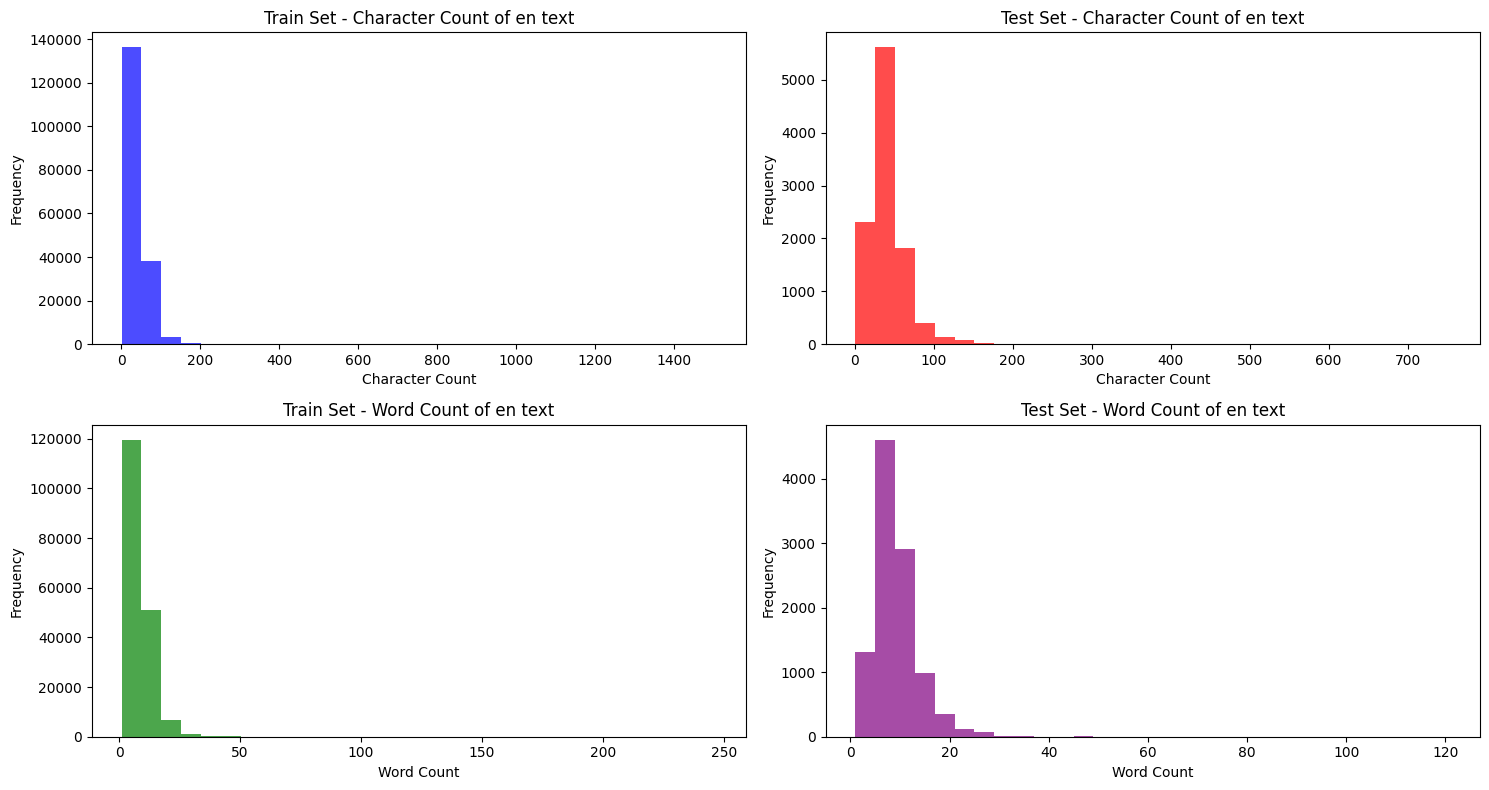

time: 4.81 s (started: 2024-02-07 06:10:14 +00:00)


In [33]:
# Accessing the train and test sets
train_data = dataset['train']
test_data = dataset['test']

# Creating Pandas DataFrame for easier handling
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Adding new columns for character count and word count of 'en' text
train_df['en_char_count'] = train_df['en'].apply(len)
train_df['en_word_count'] = train_df['en'].apply(lambda x: len(x.split()))

test_df['en_char_count'] = test_df['en'].apply(len)
test_df['en_word_count'] = test_df['en'].apply(lambda x: len(x.split()))

# Adding new columns for character count and word count of 'hi_ng' text
train_df['hi_ng_char_count'] = train_df['hi_ng'].apply(len)
train_df['hi_ng_word_count'] = train_df['hi_ng'].apply(lambda x: len(x.split()))

test_df['hi_ng_char_count'] = test_df['hi_ng'].apply(len)
test_df['hi_ng_word_count'] = test_df['hi_ng'].apply(lambda x: len(x.split()))

# Visualizing the length of 'en' text
plt.figure(figsize=(15, 8))

# Character count plots
plt.subplot(2, 2, 1)
plt.hist(train_df['en_char_count'], bins=30, color='blue', alpha=0.7)
plt.title('Train Set - Character Count of en text')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(test_df['en_char_count'], bins=30, color='red', alpha=0.7)
plt.title('Test Set - Character Count of en text')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

# Word count plots
plt.subplot(2, 2, 3)
plt.hist(train_df['en_word_count'], bins=30, color='green', alpha=0.7)
plt.title('Train Set - Word Count of en text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(test_df['en_word_count'], bins=30, color='purple', alpha=0.7)
plt.title('Test Set - Word Count of en text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [34]:
# Function to calculate and print statistics
def print_statistics(df, prefix):
    df[f'{prefix}_char_count'] = df[prefix].apply(len)
    df[f'{prefix}_word_count'] = df[prefix].apply(lambda x: len(x.split()))

    char_count_col = f'{prefix}_char_count'
    word_count_col = f'{prefix}_word_count'

    max_char = df[char_count_col].max()
    min_char = df[char_count_col].min()
    avg_char = df[char_count_col].mean()

    max_word = df[word_count_col].max()
    min_word = df[word_count_col].min()
    avg_word = df[word_count_col].mean()

    print(f"Statistics for {prefix} text:")
    print(f"Maximum character count: {max_char}")
    print(f"Minimum character count: {min_char}")
    print(f"Average character count: {avg_char:.2f}")
    print(f"Maximum word count: {max_word}")
    print(f"Minimum word count: {min_word}")
    print(f"Average word count: {avg_word:.2f}")
    print("\n")

# Print statistics for 'en' text in train set
print_statistics(train_df, 'en')

# Print statistics for 'hi_ng' text in train set
print_statistics(train_df, 'hi_ng')

# Print statistics for 'en' text in test set
print_statistics(test_df, 'en')

# Print statistics for 'hi_ng' text in test set
print_statistics(test_df, 'hi_ng')

Statistics for en text:
Maximum character count: 1508
Minimum character count: 1
Average character count: 42.07
Maximum word count: 247
Minimum word count: 1
Average word count: 8.73


Statistics for hi_ng text:
Maximum character count: 1490
Minimum character count: 1
Average character count: 47.17
Maximum word count: 273
Minimum word count: 1
Average word count: 9.40


Statistics for en text:
Maximum character count: 754
Minimum character count: 1
Average character count: 42.34
Maximum word count: 121
Minimum word count: 1
Average word count: 8.78


Statistics for hi_ng text:
Maximum character count: 588
Minimum character count: 1
Average character count: 47.18
Maximum word count: 112
Minimum word count: 1
Average word count: 9.39


time: 372 ms (started: 2024-02-07 06:10:18 +00:00)


In [35]:
# Define the create_prompt function
def create_prompt(sample):
    sys_msg= "Translate the given English Text to Hinglish."
    p =  "<s> [INST]" + sys_msg +"\n"+ sample["en"] + "[/INST]" +  sample["hi_ng"] + "</s>"
    return p 

time: 534 µs (started: 2024-02-07 06:10:19 +00:00)


In [36]:
def tokenize(prompt):
    return tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN ,
        padding="max_length"
    )

time: 366 µs (started: 2024-02-07 06:10:19 +00:00)


In [37]:
train = dataset["train"].shuffle(42)[:2000]


time: 48.9 ms (started: 2024-02-07 06:10:19 +00:00)


In [38]:
print(train)

{'en': ['switch to chats now', 'hahaha ...solid hai re baba', 'reset the alarm for 6 pm', 'Can you find the reminders about dinner ?', 'Get rid of the reminder to reschedule the meeting at work .', 'Set up a reminder for Dan that he needs to pay me for rent each month .', 'The part where he creates the email system to answer prayers and sets it to auto-reply "yes" is pretty funny and says a lot about religion.', 'Can you play classic holiday tunes', 'traffic to work today', 'Will be getting the storm today ?', "What ' s the temperature going to be today ?", 'What will the weather be on July 4th .', 'Play classic rock .', 'Is there any traffic on I 24', 'Music festivals in upstate NY', 'Will there be any rainfall this week ?', 'What is the temperature right now in North Dakota', 'Set a reminder for Friday pick up bread', "But one important institution - the U.S. government - claims not to know Hadayet's goals. An FBI spokesman has said that “there's nothing to indicate terrorism.” Anoth

In [39]:
validation = dataset["test"].shuffle(42)[:500]
test = dataset["test"].shuffle(42)[500:750]

time: 10.8 ms (started: 2024-02-07 06:10:19 +00:00)


In [40]:
print(train)

{'en': ['switch to chats now', 'hahaha ...solid hai re baba', 'reset the alarm for 6 pm', 'Can you find the reminders about dinner ?', 'Get rid of the reminder to reschedule the meeting at work .', 'Set up a reminder for Dan that he needs to pay me for rent each month .', 'The part where he creates the email system to answer prayers and sets it to auto-reply "yes" is pretty funny and says a lot about religion.', 'Can you play classic holiday tunes', 'traffic to work today', 'Will be getting the storm today ?', "What ' s the temperature going to be today ?", 'What will the weather be on July 4th .', 'Play classic rock .', 'Is there any traffic on I 24', 'Music festivals in upstate NY', 'Will there be any rainfall this week ?', 'What is the temperature right now in North Dakota', 'Set a reminder for Friday pick up bread', "But one important institution - the U.S. government - claims not to know Hadayet's goals. An FBI spokesman has said that “there's nothing to indicate terrorism.” Anoth

In [41]:
print(validation)

{'en': ['cancel alarms tomorrow', 'make timer for 10 minutes', 'How long is a flight from portland to new york', 'So is it snowing outside ?', 'Turn off all alarms', 'New York City things to do for tomorrow', 'Did I get Skype messages this morning ?', 'set an alarm for 9 am', 'send ian a message and ask him if he will put the laundry in the dryer', 'Show all reminders for Tuesday afternoon .', 'How long is a flight from NYC to Mallorca Spain', 'Is it warm is Australia in July', 'What is the fastest route to get to Roberts house from the library in Dublin', 'How long will it take mom to get to my house if she leaves right now', 'Oh my, Are you a human or robot?', 'Play Bruno Mars playlist', 'What time does the sun set', 'Is construction on the 215 done yet', 'Get me up on the 1st at 6 am', 'Message the World of Warcraft guild group that our server is down .', 'Please play some oldies', 'How long will the drive be to Newark if I leave Syracuse at 7 am ?', 'what reminders do i have', "Pla

In [42]:
print(test)

{'en': ['How far is Walgreens', 'Set reminder every Tuesday for Cross Fit .', 'Snooze all of my alarms', 'What is the driving time between Philadelphia and Richmond', 'I need reminder for tomorrow 6 am', 'How many reminders do I have for waxing appointments ?', 'What is the weather today in La Jolla ?', 'Make a repeating alarm Monday', 'Update all work reminders from 9 am to 10 am . for the month of September .', 'stop my two hour timer', 'Is it gonna be hot tomorrow', 'If I want to be in Bend by 6 pm what time should I leave', 'What will the weather be like at 7 pm', 'Can I go to the playground today ?', 'what is the traffic driving from CT to NYC', 'Set a daily alarm for 12 pm', 'Is there traffic coming home from the concert', 'Tell me the remaining time on the timer .', 'Resume that coffee timer', 'Can you remind me about my meeting on Tuesday ?', 'When is my next alarm ?', 'remind me at 8 pm to paint my nails', 'List the reminder time for my meeting with Gloria .', 'how many inches

In [43]:
def tokenize(prompt):
    return tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN ,
        padding="max_length"
    )

time: 378 µs (started: 2024-02-07 06:10:19 +00:00)


In [44]:
train_dataset = Dataset.from_dict(train)
validation_dataset = Dataset.from_dict(validation)
test_dataset = Dataset.from_dict(test)

train_data = train_dataset.map(lambda x: tokenize(create_prompt(x)), remove_columns=["en", "hi_ng"])
validation_data = validation_dataset.map(lambda x: tokenize(create_prompt(x)), remove_columns=["en", "hi_ng"])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

time: 2.04 s (started: 2024-02-07 06:10:19 +00:00)


In [45]:
from datasets import Dataset, load_dataset, load_metric

time: 316 µs (started: 2024-02-07 06:10:21 +00:00)


In [46]:
!pip install -q rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
time: 4.84 s (started: 2024-02-07 06:10:21 +00:00)


In [47]:
rouge_score = load_metric("rouge")

/tmp/ipykernel_453/1263529513.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_score = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


time: 640 ms (started: 2024-02-07 06:10:26 +00:00)


In [48]:
import numpy as np
from transformers import TrainingArguments
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Import evaluate from py-rouge package
import evaluate

# Initialize ROUGE metric using py-rouge
rouge_metric = evaluate.load("rouge")

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

def compute_metrics(eval_preds, tokenizer):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 in the preds as we can't decode them
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(pred.strip()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip()) for label in decoded_labels]

    # Calculate ROUGE scores using py-rouge
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results and convert to percentage
    result = {key: value * 100 for key, value in result.items()}

    #smoothing function
    smoothing_function = SmoothingFunction().method4

    # Calculate BLEU score for n-grams (1 to 4)
    bleu_scores = []
    for n in range(1, 5):
        weights = (1/n,) * n
        bleu_scores_n = [corpus_bleu([[ref]], [pred], weights=weights, smoothing_function=smoothing_function) for ref, pred in zip(decoded_labels, decoded_preds)]
        bleu_scores.append(sum(bleu_scores_n) / len(bleu_scores_n))

    # Calculate mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    gen_len = np.mean(prediction_lens)

    # You can process the rouge_scores, bleu_scores, and gen_len as needed
    return {
        "rouge_scores": result,
        "bleu_scores": bleu_scores,
        "gen_len": gen_len
    }

time: 542 ms (started: 2024-02-07 06:10:26 +00:00)


In [49]:
# Declare training arguments
training_args = TrainingArguments(
    output_dir="mixtral-8x7b-v0.1-english-to-hinglish-translation",
    evaluation_strategy="epoch",
    do_eval=True,
    save_strategy="epoch",
    learning_rate=1e-4,
    logging_strategy='epoch', # log according to log_steps
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    greater_is_better=True,
    # metric_for_best_model='eval_loss',
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",
    group_by_length=True,
    save_safetensors=True,
    #report_to="wandb",
    fp16=True,
    seed=42

)

# Declare trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    compute_metrics=lambda eval_preds: compute_metrics(eval_preds, tokenizer),  # Pass the tokenizer
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


time: 16.3 ms (started: 2024-02-07 06:10:27 +00:00)


In [50]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100 80GB PCIe. Max memory = 79.199 GB.
29.957 GB of memory reserved.
time: 1.24 ms (started: 2024-02-07 06:10:27 +00:00)


In [51]:
!df -h

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Filesystem      Size  Used Avail Use% Mounted on
overlay         200G   89G  112G  45% /
tmpfs            64M     0   64M   0% /dev
tmpfs           504G     0  504G   0% /sys/fs/cgroup
shm              62G  4.0K   62G   1% /dev/shm
/dev/nvme0n1p4  868G   33G  792G   4% /usr/bin/nvidia-smi
/dev/nvme1n1    200G  700K  200G   1% /workspace
tmpfs           504G   12K  504G   1% /proc/driver/nvidia
tmpfs           504G  4.0K  504G   1% /etc/nvidia/nvidia-application-profiles-rc.d
tmpfs           504G     0  504G   0% /proc/acpi
tmpfs           504G     0  504G   0% /proc/scsi
tmpfs           504G     0  504G   0% /sys/firmware
time: 410 ms (started: 2024-02-07 06:10:27 +00:00)


In [52]:
!pip install -qqq gputil psutil --progress-bar off
!pip install -qqq wandb --progress-bar off

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


time: 5.66 s (started: 2024-02-07 06:10:27 +00:00)


In [53]:

# Initialize wandb
import wandb
import GPUtil
import psutil
wandb.login()  # You might need to log in to your wandb account


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

time: 2min 2s (started: 2024-02-07 06:10:33 +00:00)


In [54]:
wandb.init(project="mixtral_mistral_llama2_english_to_hinglish", entity="drishtisharma96505", group='mixtral_8x7b_english_to_hinglish', name='mixtral_8x7b_english_to_hinglish')     

wandb: Currently logged in as: drishtisharma96505. Use `wandb login --relogin` to force relogin


time: 889 ms (started: 2024-02-07 06:12:36 +00:00)


In [55]:
import time

time: 792 µs (started: 2024-02-07 06:12:37 +00:00)


In [56]:
start_time = time.time()  # Start timer

trainer_stats = trainer.train()

end_time = time.time()  # End timer
training_duration = (end_time - start_time)/60

print(f"Training Time: {training_duration} minutes")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn

Epoch,Training Loss,Validation Loss,Rouge Scores,Bleu Scores,Gen Len
1,1.177100,1.057909,"{'rouge1': 90.70255400902434, 'rouge2': 79.76770190068221, 'rougeL': 84.00261479965636, 'rougeLsum': 90.69363147075731}","[0.00028395954091190866, 0.0002796973368739713, 0.0002722057765709132, 0.000263740024418467]",2047.996000
2,0.778800,1.076914,"{'rouge1': 90.45408202972536, 'rouge2': 79.5425441228359, 'rougeL': 83.99846297860634, 'rougeLsum': 90.43739034131012}","[0.0002881182166187815, 0.0002842750061873772, 0.0002764768847375588, 0.00026750640347869873]",2048.000000


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training Time: 190.16621324618657 minutes
time: 3h 10min 9s (started: 2024-02-07 06:12:59 +00:00)


In [57]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

11406.6945 seconds used for training.
190.11 minutes used for training.
Peak reserved memory = 74.137 GB.
Peak reserved memory for training = 44.18 GB.
Peak reserved memory % of max memory = 93.609 %.
Peak reserved memory for training % of max memory = 55.784 %.
time: 3.53 ms (started: 2024-02-07 09:23:09 +00:00)


In [58]:
wandb.log({
    'Model Name': 'mistralai/Mixtral-8x7B-v0.1',
    'Dataset': 'nateraw/english-to-hinglish',
    'Key Features': 'Flash Attention 2, No Unsloth, No NEFTune',
    'Hardware Specifications': 'GPU = {}, Max memory = {} GB'.format(gpu_stats.name, max_memory),
    'Training Time (minutes)': training_duration,
    'Training Arguments': training_args.to_dict(),
    'Memory Stats': {
        'Start GPU Memory (GB)': start_gpu_memory,
        'Peak Reserved Memory (GB)': used_memory,
        'Peak Reserved Memory for Training (GB)': used_memory_for_lora,
        'Peak Reserved Memory % of Max Memory': used_percentage,
        'Peak Reserved Memory for Training % of Max Memory': lora_percentage
    },
    'Training Runtime (seconds)': trainer_stats.metrics['train_runtime'],
    'Peak Reserved Memory (GB)': used_memory  # Added missing parameter
})

time: 2.75 ms (started: 2024-02-07 09:23:16 +00:00)


In [59]:
from huggingface_hub import notebook_login
notebook_login()

time: 20 ms (started: 2024-02-07 09:23:19 +00:00)


In [60]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DrishtiSharma/mixtral-8x7b-v0.1-english-to-hinglish-translation/commit/4c9d06abebf89d41a18e7105780773cb2495dcd3', commit_message='End of training', commit_description='', oid='4c9d06abebf89d41a18e7105780773cb2495dcd3', pr_url=None, pr_revision=None, pr_num=None)

time: 1min 21s (started: 2024-02-07 09:27:11 +00:00)


In [61]:
new_model = "DrishtiSharma/mixtral-8x7b-v0.1-english-to-hinglish-translation"
mixtral_checkpoint = "mistralai/Mixtral-8x7B-v0.1"

time: 1.35 ms (started: 2024-02-07 09:29:04 +00:00)


In [62]:
base_model = AutoModelForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-v0.1",
                                             load_in_4bit=True,
                                             torch_dtype=torch.float16,
                                             device_map="cuda",
                                             attn_implementation="flash_attention_2",   #You can use flash attention on your local GPU with specific libraries
                                             )

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

time: 1min 22s (started: 2024-02-07 09:29:12 +00:00)


In [63]:
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

adapter_config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:249: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


time: 4min 5s (started: 2024-02-07 09:30:34 +00:00)


In [64]:
# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(mixtral_checkpoint, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


time: 118 ms (started: 2024-02-07 09:34:40 +00:00)


In [65]:
tokenizer

LlamaTokenizerFast(name_or_path='mistralai/Mixtral-8x7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

time: 3.76 ms (started: 2024-02-07 09:34:40 +00:00)


In [ ]:
model.push_to_hub("mixtral-8x7b-v0.1-english-to-hinglish-translation-merged")
tokenizer.push_to_hub("mixtral-8x7b-v0.1-english-to-hinglish-translation-merged")

model-00002-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.67G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]